In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

import kornia.augmentation as K 

import numpy as np
import pandas as pd

In [24]:
data_dir = "Deep_Learning/Project (Spectral)/Data/ot"
train_csv = pd.read_csv("C:/IIUM/AI Note IIUM/Deep_Learning/Project (Spectral)/Data/test.csv")
test_csv = pd.read_csv("C:/IIUM/AI Note IIUM/Deep_Learning/Project (Spectral)/Data/test.csv")

In [25]:
BANDS = 100
BATCH_SIZE = 32
EPOCHS = 50
LEARNING_RATE = 0.001
NUM_BANDS = 100
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [26]:
class HyperspectralDataset(Dataset):
    def __init__(self, dataframe, base_path, patch_size=64, augment=False, num_bands=NUM_BANDS):  # Use NUM_BANDS variable
        super().__init__()
        self.df = dataframe.reset_index(drop=True)
        self.base_path = base_path
        self.patch_size = patch_size
        self.augment = augment
        self.num_bands = num_bands

        # Set up transformations
        self.transform = K.AugmentationSequential(
            K.RandomHorizontalFlip(p=0.3),
            K.RandomVerticalFlip(p=0.3),
            K.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.95, 1.05), p=0.5),
            K.RandomCrop((patch_size, patch_size), padding=4, p=0.5),
            data_keys=["input"]
        ) if augment else None

    def __len__(self):
        return len(self.df)

    def _load_image(self, img_path):
        try:
            img = np.load(img_path)
            if img.ndim == 2:
                img = np.repeat(img[:, :, None], self.num_bands, axis=2)
            elif img.shape[2] != self.num_bands:
                diff = self.num_bands - img.shape[2]
                if diff > 0:
                    img = np.pad(img, ((0,0), (0,0), (0,diff)), mode='constant')
                else:
                    img = img[:, :, :self.num_bands]
            return img.astype(np.float32) / 65535.0
        except Exception as e:
            print(f"💀 Error loading {img_path}: {e}")
            return np.zeros((self.patch_size, self.patch_size, self.num_bands), dtype=np.float32)

    def _prepare_tensor(self, img_np):
        img_tensor = torch.from_numpy(img_np).permute(2, 0, 1)  # [C, H, W]
        if self.augment:
            img_tensor = self.transform(img_tensor.unsqueeze(0))[0] # type: ignore
        if img_tensor.shape[1:] != (self.patch_size, self.patch_size):
            img_tensor = F.interpolate(img_tensor.unsqueeze(0), size=(self.patch_size, self.patch_size), mode='bilinear').squeeze(0)
        return img_tensor

    def _process_label(self, raw_label):
        label = torch.tensor(raw_label, dtype=torch.long)
        return label - 1 if label > 0 else label

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = os.path.join(self.base_path, row['id'])
        img_np = self._load_image(img_path)
        img_tensor = self._prepare_tensor(img_np)
        label_tensor = self._process_label(row['label'])
        return img_tensor, label_tensor

In [27]:
class SpatialAttention(nn.Module):
    def __init__(self, kernel_size=7):
        super(SpatialAttention, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(2, 8, kernel_size, padding=kernel_size//2),
            nn.ReLU(),
            nn.Conv2d(8, 1, kernel_size=1)
        )
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        concat = torch.cat([avg_out, max_out], dim=1)
        attention = self.sigmoid(self.conv(concat))
        return x * attention


In [28]:
class ChannelAttention(nn.Module):
    def __init__(self, in_channels, reduction_ratio=16):
        super(ChannelAttention, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.max_pool = nn.AdaptiveMaxPool2d(1)
        
        self.fc = nn.Sequential(
            nn.Linear(in_channels, in_channels // reduction_ratio),
            nn.ReLU(inplace=True),
            nn.Linear(in_channels // reduction_ratio, in_channels),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        avg_out = self.fc(self.avg_pool(x).view(b, c))
        max_out = self.fc(self.max_pool(x).view(b, c))
        out = avg_out + max_out
        return out.view(b, c, 1, 1)

In [29]:
class HyperspectralCNN(nn.Module):
    def __init__(self, in_channels=NUM_BANDS, num_classes=100):
        super().__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca1 = ChannelAttention(64)
        self.sa1 = SpatialAttention()
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.1, inplace=True),
            nn.MaxPool2d(2)
        )
        
        self.ca2 = ChannelAttention(128)
        self.sa2 = SpatialAttention()
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.1, inplace=True),
            nn.AdaptiveAvgPool2d(1)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(256, 128),
            nn.SiLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 64),
            nn.SiLU(),
            nn.Linear(64, num_classes) 
        )
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.ca1(x) * x
        x = self.sa1(x) * x
        
        x = self.conv2(x)
        x = self.ca2(x) * x
        x = self.sa2(x) * x
        
        x = self.conv3(x)
        x = x.view(x.size(0), -1)
        return self.classifier(x)

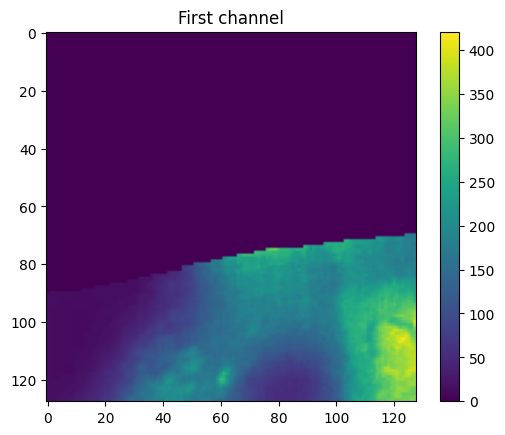

In [36]:
sample = np.load('C:/IIUM/AI Note IIUM/Deep_Learning/Project (Spectral)/Data/ot/sample3.npy')  # (128, 128, 125)
plt.imshow(sample[:, :, 0])
plt.title('First channel')
plt.colorbar()
plt.show() 